In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree as tree
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')  
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA
We have a training dataset which contains several columns. Some of these columns are expectedly disposable, as they barely affect the survivability of the passenger. The problem starts with the selection of attributes.
First off, let us check for missing values in the dataset.

In [3]:
df = train_data
df_test = test_data
np.shape(df)

(891, 12)

The dataset contains 891 rows.

In [4]:
pd.isna(df).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Off these 891 rows, 177 are missing information about the Passenger's age, and 687 missing information about the Passenger's Cabin.

As a large percentage of Cabin information is missing, it would be wise to completely drop this attribute, instead of attempting to fill in the missing values. Let us also drop two extra columns, PassengerId and Ticket, as these will not influence the survivability in any way.

In [5]:
df = df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


All that's missing now is deciding what to do with the column Age's missing values. I decided to fill them, with the mean of the column.

In [6]:
df = df.fillna(df['Age'].mean())
df_test = df_test.fillna(df_test['Age'].mean())
pd.isna(df).sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Now that the missing values are dealt with, and uninteresting columns have been dropped, let's evaluate each column.
The SibSp and Parch columns may be simplified in one, that would just give information about if the passenger had any family on the boat or not.

In [7]:
Family = train_data['SibSp'] + train_data['Parch']
fam = pd.Series(Family)
fam = fam.rename('Family')
df = pd.concat([df, fam], axis=1)
df = df.drop(['SibSp', 'Parch', ], axis=1)

Family = test_data['SibSp'] + test_data['Parch']
fam = pd.Series(Family)
fam = fam.rename('Family')
df_test = pd.concat([df_test, fam], axis=1)
df_test = df_test.drop(['SibSp', 'Parch', ], axis=1)

df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S,0


As we are not interested in the amount of family members the passenger had in the boat, only if the passenger had any, we'll reformulate the Family Column into a binary column.

In [8]:
df.loc[df['Family'] > 1, 'Family'] = 1
df_test.loc[df_test['Family'] > 1, 'Family'] = 1
df['Family'].value_counts()

0    537
1    354
Name: Family, dtype: int64

Onto the Sex column, let's change it from categorical to binary.

In [9]:
df['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df_test['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family
0,0,3,"Braund, Mr. Owen Harris",0,22.0,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",0,35.0,8.0500,S,0


Let us analyse the Embarked column now.

In [10]:
df['Embarked'].value_counts()

S                    644
C                    168
Q                     77
29.69911764705882      2
Name: Embarked, dtype: int64

In [11]:
df_test['Embarked'].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

We see that, for some reason, there are 2 numerical values in the Embarked column. Let us replace them with the mode of the column.

In [12]:
df.loc[df['Embarked'] == 29.69911764705882, 'Embarked'] = 'S'
df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Much better. Let's change the 3 designations into values, 0 for S, 1 for C, 2 for Q.

In [13]:
df['Embarked'].replace(to_replace=['S','C', 'Q'], value=[0,1,2],inplace=True)
df_test['Embarked'].replace(to_replace=['S','C', 'Q'], value=[0,1,2],inplace=True)
df['Embarked'].value_counts()

0    646
1    168
2     77
Name: Embarked, dtype: int64

The last column that demands some explanation/exploration is the Name column. I believe it would be quite interesting to correlate the title of the people to their survivability, e.g., Mr., Mrs., Miss, etc.

In [14]:
aux_df = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
aux_df_test = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
aux_df.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Name, dtype: int64

So we have 4 common titles, 'Mr', 'Miss', 'Mrs', and 'Master'. First, let's correct the random designations (like 'Mlle', 'Ms', and 'MMe'), and attribute Rare to the random ones.

In [15]:
aux_df = aux_df.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
aux_df = aux_df.replace('Mlle', 'Miss')
aux_df = aux_df.replace('Ms', 'Miss')
aux_df = aux_df.replace('Mme', 'Mrs')

aux_df_test = aux_df_test.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
aux_df_test = aux_df_test.replace('Mlle', 'Miss')
aux_df_test = aux_df_test.replace('Ms', 'Miss')
aux_df_test = aux_df_test.replace('Mme', 'Mrs')

aux_df.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Name, dtype: int64

And now, let's turn them into numerical!

In [16]:
aux_df.replace(to_replace=['Mr','Miss', 'Mrs', 'Master', 'Rare'], value=[0,1,2,3,4],inplace=True)
aux_df_test.replace(to_replace=['Mr','Miss', 'Mrs', 'Master', 'Rare'], value=[0,1,2,3,4],inplace=True)
aux_df.value_counts()

0    517
1    185
2    126
3     40
4     23
Name: Name, dtype: int64

Now, to drop the 'Name' column from the main df, and attach the new one, named 'Titles'.

In [17]:
aux_df = aux_df.rename('Title')
df = pd.concat([df, aux_df], axis=1)
df = df.drop(['Name'], axis=1)

aux_df_test = aux_df_test.rename('Title')
df_test = pd.concat([df_test, aux_df_test], axis=1)
df_test = df_test.drop(['Name'], axis=1)

df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family,Title
0,0,3,0,22.0,7.2500,0,1,0
1,1,1,1,38.0,71.2833,1,1,2
2,1,3,1,26.0,7.9250,0,0,1
3,1,1,1,35.0,53.1000,0,1,2
4,0,3,0,35.0,8.0500,0,0,0


Now, all that's left is turning Age and Fare into categorical variables.


Starting with Age, let's use these Age separation intervals:

* 0-10: 0
* 11-17: 1
* 18-21: 2
* 22-26: 3
* 27-32: 4
* 33-39: 5
* 40-65: 6
* 66+: 7

In [18]:
df.loc[df['Age'] < 11, 'Age'] = 0
df.loc[(df['Age'] >=11) & (df['Age'] < 18), 'Age'] = 1
df.loc[(df['Age'] >=18) & (df['Age'] < 22), 'Age'] = 2
df.loc[(df['Age'] >=22) & (df['Age'] < 27), 'Age'] = 3
df.loc[(df['Age'] >=27) & (df['Age'] < 33), 'Age'] = 4
df.loc[(df['Age'] >=33) & (df['Age'] < 40), 'Age'] = 5
df.loc[(df['Age'] >=40) & (df['Age'] < 66), 'Age'] = 6
df.loc[df['Age'] >=66, 'Age'] = 7

df_test.loc[df_test['Age'] < 11, 'Age'] = 0
df_test.loc[(df_test['Age'] >=11) & (df_test['Age'] < 18), 'Age'] = 1
df_test.loc[(df_test['Age'] >=18) & (df_test['Age'] < 22), 'Age'] = 2
df_test.loc[(df_test['Age'] >=22) & (df_test['Age'] < 27), 'Age'] = 3
df_test.loc[(df_test['Age'] >=27) & (df_test['Age'] < 33), 'Age'] = 4
df_test.loc[(df_test['Age'] >=33) & (df_test['Age'] < 40), 'Age'] = 5
df_test.loc[(df_test['Age'] >=40) & (df_test['Age'] < 66), 'Age'] = 6
df_test.loc[df_test['Age'] >=66, 'Age'] = 7

df['Age'].value_counts()

4.0    306
6.0    155
3.0    115
5.0    103
2.0     91
0.0     64
1.0     49
7.0      8
Name: Age, dtype: int64

And now, all that's left is Fare. I have no idea what a low or high fare was in those times, I found some tables online that gave out these intervals:
* 0-7.91: Extremely Low
* 7.91-14.454: Very Low
* 14.454-31: Low
* 31-99: High
* 99-250: Very high
* 250+: Extremely high

In [19]:
df.loc[df['Fare'] < 7.91, 'Fare'] = 0
df.loc[(df['Fare'] >= 7.91) & (df['Fare'] < 14.454), 'Fare'] = 1
df.loc[(df['Fare'] >= 14.454) & (df['Fare'] < 31), 'Fare'] = 2
df.loc[(df['Fare'] >= 31) & (df['Fare'] < 99), 'Fare'] = 3
df.loc[(df['Fare'] >= 99) & (df['Fare'] < 250), 'Fare'] = 4
df.loc[df['Fare'] >= 250, 'Fare'] = 5

df_test.loc[df_test['Fare'] < 7.91, 'Fare'] = 0
df_test.loc[(df_test['Fare'] >= 7.91) & (df_test['Fare'] < 14.454), 'Fare'] = 1
df_test.loc[(df_test['Fare'] >= 14.454) & (df_test['Fare'] < 31), 'Fare'] = 2
df_test.loc[(df_test['Fare'] >= 31) & (df_test['Fare'] < 99), 'Fare'] = 3
df_test.loc[(df_test['Fare'] >= 99) & (df_test['Fare'] < 250), 'Fare'] = 4
df_test.loc[df_test['Fare'] >= 250, 'Fare'] = 5

df['Fare'].value_counts()

2.0    226
0.0    223
1.0    217
3.0    172
4.0     44
5.0      9
Name: Fare, dtype: int64

Finally, let's check the correlation matrix.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'Survived'),
  Text(1.5, 0, 'Pclass'),
  Text(2.5, 0, 'Sex'),
  Text(3.5, 0, 'Age'),
  Text(4.5, 0, 'Fare'),
  Text(5.5, 0, 'Embarked'),
  Text(6.5, 0, 'Family'),
  Text(7.5, 0, 'Title')])

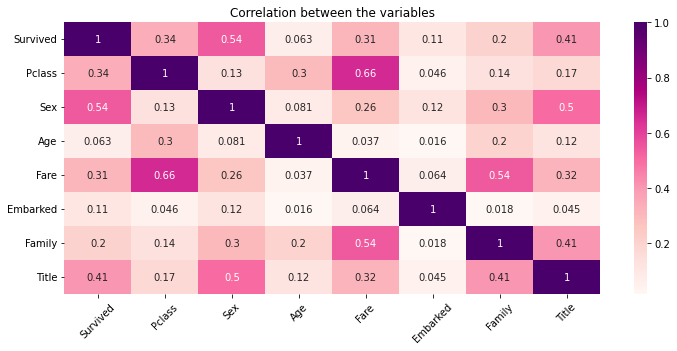

In [20]:
#correlation matrix and the heatmap
plt.subplots(figsize=(12,5))
correlation=abs(df.corr())
sns.heatmap(correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)

Surprisingly, Age looks completely irrelevant to the passenger's survivability. I'll create several dataframes, including more or less attributes, by order or correlation with the survivability.

In [21]:
y_train = df['Survived'].values
df1 = df.drop(['Survived'], axis=1)
df2 = df.drop(['Survived', 'Age'], axis=1)
df3 = df.drop(['Survived', 'Age', 'Embarked'], axis=1)
df4 = df.drop(['Survived', 'Age', 'Embarked', 'Family'], axis=1)
df4 = df.drop(['Survived', 'Age', 'Embarked', 'Family', 'Fare'], axis=1)
df5 = df.drop(['Survived', 'Age', 'Embarked', 'Family', 'Fare', 'Pclass'], axis=1)
df6 = df.drop(['Survived', 'Age', 'Embarked', 'Family', 'Fare', 'Pclass', 'Title'], axis=1)
df_list = [df1, df2, df3, df4, df5, df6]

# Machine Learning modeling
I'll opt for a Logistic Regression algorithm, with optimization of the hyperparameters via GridSearchCV.

I'll also keep the accuracy of the Grid Search for each of the different data frames.

In [22]:
param_logreg={'C': [0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}
best_params = []
best_score = []

for i, X_train in enumerate(df_list):
    logreg_cv=GridSearchCV(LogisticRegression(), param_logreg, cv=10, scoring='accuracy')
    logreg_cv.fit(X_train.values, y_train)
    best_params.append([i, logreg_cv.best_params_])
    best_score.append([i, logreg_cv.best_score_])
    
print(best_params, '\n', best_score)

[[0, {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}], [1, {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}], [2, {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}], [3, {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}], [4, {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}], [5, {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}]] 
 [[0, 0.8080774032459426], [1, 0.7968539325842696], [2, 0.7822471910112359], [3, 0.7889762796504369], [4, 0.7755056179775281], [5, 0.786729088639201]]


So, the best was an 80.8% of accuracy, which is disapointing. I'll go through the other algorithms, KNN, Decision Tree, and SVM.

In [23]:
k_range=list(range(1,30))
param_knn=dict(n_neighbors = k_range, algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'])
best_params = []
best_score = []

for i, X_train in enumerate(df_list):
    knn_cv=GridSearchCV(KNeighborsClassifier(), param_knn, cv=10, scoring='accuracy')
    knn_cv.fit(X_train.values, y_train)
    best_params.append([i, knn_cv.best_params_])
    best_score.append([i, knn_cv.best_score_])
    
print(best_params, '\n', best_score)

[[0, {'algorithm': 'ball_tree', 'n_neighbors': 8}], [1, {'algorithm': 'brute', 'n_neighbors': 21}], [2, {'algorithm': 'auto', 'n_neighbors': 9}], [3, {'algorithm': 'brute', 'n_neighbors': 4}], [4, {'algorithm': 'auto', 'n_neighbors': 27}], [5, {'algorithm': 'auto', 'n_neighbors': 3}]] 
 [[0, 0.8115106117353308], [1, 0.813732833957553], [2, 0.8103620474406992], [3, 0.8035830212234707], [4, 0.7901373283395754], [5, 0.786729088639201]]


Best accuracy was for df2, with a value of 81.4%

In [24]:
param_tree={'criterion':['gini', 'entropy'], 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150], 'splitter':['best', 'random']}
best_params = []
best_score = []

for i, X_train in enumerate(df_list):
    tree_cv=GridSearchCV(DecisionTreeClassifier(), param_tree, cv=10, scoring='accuracy')
    tree_cv.fit(X_train.values, y_train)
    best_params.append([i, tree_cv.best_params_])
    best_score.append([i, tree_cv.best_score_])
    
print(best_params, '\n', best_score)

[[0, {'criterion': 'entropy', 'max_depth': 7, 'splitter': 'random'}], [1, {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}], [2, {'criterion': 'entropy', 'max_depth': 6, 'splitter': 'random'}], [3, {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}], [4, {'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}], [5, {'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}]] 
 [[0, 0.813732833957553], [1, 0.8192883895131086], [2, 0.8069787765293382], [3, 0.7766791510611736], [4, 0.7935081148564295], [5, 0.786729088639201]]


Best result is 81.6%, still better than LogReg, tying it close with KNN.

In [25]:
param_svm={'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
best_params = []
best_score = []

for i, X_train in enumerate(df_list):
    svm_cv=GridSearchCV(SVC(), param_svm, cv=10, scoring='accuracy')
    svm_cv.fit(X_train.values, y_train)
    best_params.append([i, svm_cv.best_params_])
    best_score.append([i, svm_cv.best_score_])
    
print(best_params, '\n', best_score)

[[0, {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}], [1, {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}], [2, {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}], [3, {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}], [4, {'C': 1, 'gamma': 1, 'kernel': 'rbf'}], [5, {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}]] 
 [[0, 0.823820224719101], [1, 0.8204119850187265], [2, 0.8170162297128589], [3, 0.7968414481897628], [4, 0.7935081148564295], [5, 0.786729088639201]]


And SVM with a maximum of 82.4%, which is the highest so far. I will now export CSV files respective to each of the algorithms best results, and after feeding it to Kaggle, will return with the accuracy in the test data.

# CSV creation

In [26]:
df1_test = df_test
df2_test = df_test.drop(['Age'], axis=1)

#KNN - df2, algorithm=brute, n_neighbors=21
knn=KNeighborsClassifier(algorithm='ball_tree', n_neighbors=8)
knn.fit(df1.values, y_train)
yhat = knn.predict(df1_test.values)
yhat=pd.Series(data=yhat)
yhat=yhat.rename('Survived')
result=pd.concat([test_data['PassengerId'], yhat], axis=1)
result.to_csv('/kaggle/working/knn_df1.csv', index=False)

#Tree - df1, criterion=entropy, max_depth=6, spliiter=random
tree=DecisionTreeClassifier(criterion='entropy', max_depth=6, splitter='random')
tree.fit(df1.values, y_train)
yhat = tree.predict(df1_test.values)
yhat=pd.Series(data=yhat)
yhat=yhat.rename('Survived')
result=pd.concat([test_data['PassengerId'], yhat], axis=1)
result.to_csv('/kaggle/working/tree.csv', index=False)

#Tree - df1, C=1000, gamma=0.01, kernel=rbf
svm=SVC(C=1000, gamma=0.01, kernel='rbf')
svm.fit(df1.values, y_train)
yhat = svm.predict(df1_test.values)
yhat=pd.Series(data=yhat)
yhat=yhat.rename('Survived')
result=pd.concat([test_data['PassengerId'], yhat], axis=1)
result.to_csv('/kaggle/working/svm.csv', index=False)

#LogReg - df1, C=1, penalty=l1, solver=liblinear
logreg=LogisticRegression(C=1, penalty='l1', solver='liblinear')
logreg.fit(df1.values, y_train)
yhat = logreg.predict(df1_test.values)
yhat=pd.Series(data=yhat)
yhat=yhat.rename('Survived')
result=pd.concat([test_data['PassengerId'], yhat], axis=1)
result.to_csv('/kaggle/working/logreg.csv', index=False)

# Final Results

After submission, I have obtained the following accuracy values:
* KNN - 78.5%
* Decision Tree - 77.8%
* SVM - 78.5%
* Logistic Regression - 77.8%

The accuracy score of 78.5% put me at the position 2000, which I feel very happy about, since this is my first project.

I have observed some of the higher scores, and they either go for Deep Learning approaches, or Random Tree Classifiers, which I know nothing about.

This was my 3rd version of this challenge, and I feel like I have learned a lot, mostly about EDA and Feature Engineering.

The 1st version was a simple one, which returned an accuracy of 76%, and my 2nd version envolved some Feature Engineering, but returned lower values than my 1st version.

See you in the next project,

Frederico Direito